This notebook, is looking at way to compare the logits, logprobs, and logs of chosen completions. We hope to find a way this is more information rich than accuracy and can differentiate between the models better

it should
- be like accuracy (0 to 1), high on easy datasets
- be able to differentiate between models well
- ideally we can use it without a hard cutoff, making it more information rich than accuracy. Perhaps we will need to calibrate or scale the logprobs first.

Findings:
- dpo and ipo accuracy are not as good as just looking at the first divering token. This makes sense as DPO considers the probability of the whole completion, this is problematic as longers completions are less likely. IPO is better, it consider all tokens equally, but we don't actually want to a consider later tokens. Imagine a string that starts with an unlikely token SolidGoldMagikarp, then continues with a very likely lorem ipsum. IPO would consider this completion very likely, but it's actually unlikely to be selected. Instead we only consider the first divering token. 
- For example if we are comparing ["The cat is on the mat", "The dog is on the mat"], then the first diverging token is "cat" and "dog". We can then compare the logprobs of these tokens directly to get the best score.

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from dataclasses import dataclass, field
from datasets import Dataset, features
import tempfile
from trl import DPOConfig, DPOTrainer
from typing import Optional
from transformers import AutoTokenizer, AutoModelForCausalLM

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


from open_pref_eval.trainer import dummy_dataset, OPEConfig
from open_pref_eval.evaluation import eval_dpo_dataset

In [3]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from typing import List, Tuple

import seaborn as sns
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [5, 5]

## Ds

In [4]:
from open_pref_eval.datasets import get_default_datasets

# choose two pretty easy ones
datasets = get_default_datasets(20)[:2]

from datasets import concatenate_datasets
dataset = concatenate_datasets(datasets)
dataset

Generating validation split:   0%|          | 0/817 [00:00<?, ? examples/s]

Dataset({
    features: ['prompt', 'chosen', 'rejected', 'id'],
    num_rows: 40
})

In [5]:
from open_pref_eval.datasets.imdb import load_imdb_dpo
# very easy task
dataset = load_imdb_dpo().shuffle().select(range(300))
# dataset['label']

ModuleNotFoundError: No module named 'open_pref_eval.datasets.imdb'

In [ ]:
dataset['chosen']

In [ ]:
r = dataset[22]
print(r['prompt'])
r

Question: Does the following movie review have positive or negative in sentiment?

Review: Set in Venice mainly on the Lido, Visconti's "Death in Venice" is a triumph of filmmaking combining the excellence of Dirk Bogarde's characterisation and expert photography of the resort area in all its various daily moods. For those who love Venice, this is a film to cherish.<br /><br />Mahler's music frequently heard throughout the film heightens the drama. The mood it creates is not always happy. But then what else would you expect with a title like that?<br /><br />There is not a lot of dialogue in the film. Rather sparse in fact. It's mainly background noises and chatter and laughter among the hotel guests. The intriguing part is to interpret the exchange of glances between Gustav von Aschenbach a composer of some renown and a slim teenage youth Tadzio who see each other from time to time across the tables of the hotel dining room, on the beach and at odd unexpected places around Venice. The

{'prompt': 'Question: Does the following movie review have positive or negative in sentiment?\n\nReview: Set in Venice mainly on the Lido, Visconti\'s "Death in Venice" is a triumph of filmmaking combining the excellence of Dirk Bogarde\'s characterisation and expert photography of the resort area in all its various daily moods. For those who love Venice, this is a film to cherish.<br /><br />Mahler\'s music frequently heard throughout the film heightens the drama. The mood it creates is not always happy. But then what else would you expect with a title like that?<br /><br />There is not a lot of dialogue in the film. Rather sparse in fact. It\'s mainly background noises and chatter and laughter among the hotel guests. The intriguing part is to interpret the exchange of glances between Gustav von Aschenbach a composer of some renown and a slim teenage youth Tadzio who see each other from time to time across the tables of the hotel dining room, on the beach and at odd unexpected places 

## Helpers

In [ ]:
# custom trainer that return full logits, so I can practice....
class OPETrainer2(DPOTrainer):

    @staticmethod
    def get_batch_logps(
        logits: torch.FloatTensor,
        labels: torch.LongTensor,
        label_pad_token_id: int = -100,
        is_encoder_decoder: bool = False,
    ) -> Tuple[torch.FloatTensor, torch.LongTensor]:
        if logits.shape[:-1] != labels.shape:
            raise ValueError("Logits (batch and sequence length dim) and labels must have the same shape.")

        if not is_encoder_decoder:
            labels = labels[:, 1:].clone()
            logits = logits[:, :-1, :]
        loss_mask = labels != label_pad_token_id

        # dummy token; we'll ignore the losses on these tokens later
        labels[labels == label_pad_token_id] = 0

        per_token_logps = torch.gather(logits.log_softmax(-1), dim=2, index=labels.unsqueeze(2)).squeeze(2)

        return per_token_logps, loss_mask


    def concatenated_forward(
        self, model, batch):

        concatenated_batch = self.concatenated_inputs(
            batch,
            is_encoder_decoder=self.is_encoder_decoder,
            is_vision_model=self.is_vision_model,
            label_pad_token_id=self.label_pad_token_id,
            padding_value=self.padding_value,
            device=self.accelerator.device,
        )
        len_chosen = batch["chosen_labels"].shape[0]

        model_kwargs = {}

        # if self.is_encoder_decoder:
        #     model_kwargs["labels"] = concatenated_batch["concatenated_labels"]
        #     model_kwargs["decoder_input_ids"] = concatenated_batch.pop("concatenated_decoder_input_ids", None)

        # if self.is_vision_model:
        #     model_kwargs["pixel_values"] = concatenated_batch["pixel_values"]
        #     model_kwargs["pixel_attention_mask"] = concatenated_batch["pixel_attention_mask"]

        # if self.aux_loss_enabled:
        #     model_kwargs["output_router_logits"] = True

        outputs = model(
            concatenated_batch["concatenated_input_ids"],
            attention_mask=concatenated_batch["concatenated_attention_mask"],
            use_cache=False,
            **model_kwargs,
        )
        all_logits = outputs.logits

        all_logps, mask = self.get_batch_logps(
            all_logits,
            concatenated_batch["concatenated_labels"],
            # average_log_prob=self.loss_type == "ipo",
            is_encoder_decoder=self.is_encoder_decoder,
            label_pad_token_id=self.label_pad_token_id,
        )

        chosen_logps = all_logps[:len_chosen]
        rejected_logps = all_logps[len_chosen:]

        chosen_mask = mask[:len_chosen]
        rejected_mask = mask[len_chosen:]

        chosen_logits = all_logits[:len_chosen]
        rejected_logits = all_logits[len_chosen:]

        return (chosen_logps, rejected_logps, chosen_logits, rejected_logits, chosen_mask, rejected_mask)
    # concatenated_forward

def get_dummy_trainer2(model=None, tokenizer=None, model_name:Optional[str]=None, per_device_eval_batch_size=8, **kwargs):
    """
    Make a dummy trainer, 

    For keyword arguments, see 
    - [transformers.TrainingArguments](https://huggingface.co/docs/transformers/v4.43.3/en/main_classes/trainer#transformers.TrainingArguments)
    - [trl.DPOConfig](https://huggingface.co/docs/trl/main/en/dpo_trainer#trl.DPOConfig)

    """
    with tempfile.TemporaryDirectory() as tmp_dir:
        training_args = OPEConfig(
            output_dir=tmp_dir,
            per_device_eval_batch_size=per_device_eval_batch_size,
            loss_type='dpo',
            **kwargs
        )

    if model_name is not None:
        model = AutoModelForCausalLM.from_pretrained(model_name)
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token

    if model is None:
        raise ValueError('model or model_name must be provided')

    # we rse a TRL class
    trainer = OPETrainer2(
        model=model,
        ref_model=None,
        args=training_args,
        tokenizer=tokenizer,
        train_dataset=dummy_dataset,
        eval_dataset=dummy_dataset,
    )
    return trainer




In [ ]:
from open_pref_eval.helpers.load_models import load_peft_model

model_name = "gepardzik/LLama-3-8b-rogue-lora"

model, tokenizer = load_peft_model(model_name)

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
`low_cpu_mem_usage` was None, now set to True since model is quantized.


In [ ]:
trainer = get_dummy_trainer2(model=model, tokenizer=tokenizer, per_device_eval_batch_size=6)
trainer

Map:   0%|          | 0/9 [00:00<?, ? examples/s]

Map:   0%|          | 0/9 [00:00<?, ? examples/s]

In [ ]:
import gc

def clear_mem():
    gc.collect()
    torch.cuda.empty_cache()

In [ ]:
from open_pref_eval.evaluation import eval_dpo_dataset, load_dataset, ds2name, is_peft_model, is_peft_model, set_adapter
from trl import DPOTrainer
from typing import Optional, List, Union
from datasets import Dataset
from contextlib import contextmanager, nullcontext
from tqdm.auto import tqdm


def extract_logps(trainer, model, batch, step):
    bs = batch['chosen_input_ids'].shape[0]
    i = bs * step + torch.arange(bs)
    
    (chosen_logps, rejected_logps, chosen_logits, rejected_logits, chosen_mask, rejected_mask) = trainer.concatenated_forward(model, batch)

    # Note: if we are using ipo or reprpo this will be adjusted for length, but otherwise not which would bias the results
    # logratio = chosen_logps-rejected_logps

    # turn into list of dicts
    n = dict(
        # logps
        # _logratio=logratio.detach().cpu().float().numpy(),
        _chosen_logps=chosen_logps.detach().cpu().float(),
        _rejected_logps=rejected_logps.detach().cpu().float(),

        # masks
        _chosen_mask=chosen_mask.detach().cpu().float(),
        _rejected_mask=rejected_mask.detach().cpu().float(),

        # completion length, for checking if the model is biased
        # _l_chosen=(batch['chosen_labels']>0).sum(-1).detach().cpu().float().numpy(),
        # _l_rejected=(batch['rejected_labels']>0).sum(-1).detach().cpu().float().numpy(),

        # metadata
        ds_i=i.numpy(),

                    
    )
    return [dict(
        model=trainer.model.config._name_or_path,
        # arrays
        **{k:v[i] for k,v in n.items()}
    ) for i in range(bs)]

@torch.no_grad()
def eval_dpo_dataset(trainer: DPOTrainer, dataset: Union[Dataset,str]):
    """
    We eval the prob_chosen/prob_rejected for each sample in the dataset (per token)

    Must have cols chosen and rejected just like the trl dpotrainer

    see trainer.evaluation_loop
    """
    if isinstance(dataset, str):
        dataset_name, split = dataset.split('#')
        dataset = load_dataset(dataset_name, split=split, keep_in_memory=False)

    model = trainer.model
    model.eval()
    model.config.use_cache = False


    data = []
    # use hf dpo trainer to tokenizer, and make loader
    dataset2 = dataset.map(trainer.tokenize_row, num_proc=trainer.dataset_num_proc, writer_batch_size=10)
    eval_dataloader = trainer.get_eval_dataloader(dataset2)

    # HACK
    # assert trainer.loss_type == 'ipo', 'only ipo is supported, since it gives us the avg of logps, and is not biased by response length'
    
    compte_ref_context_manager = torch.cuda.amp.autocast if trainer._peft_has_been_casted_to_bf16 else nullcontext
    
    with compte_ref_context_manager():
        for step, batch in enumerate(tqdm(eval_dataloader, desc=f"Eval {ds2name(dataset)}")):
            # FIXME test
            # batch = trainer._prepare_inputs(batch)

            if is_peft_model(model):
                # if model has peft adapters loop through them
                adapters = [None] +list(model.peft_config.keys())
                for adapter_name in adapters:
                    with set_adapter(model, adapter_name):
                        d = extract_logps(trainer, model, batch, step)
                        for dd in d:
                            dd['adapter'] = adapter_name if adapter_name is not None else 'base'
                            data.append(dd)
            else:
                data += extract_logps(trainer, model, batch, step)

            clear_mem()

    df = pd.DataFrame(data)

    df['dataset'] = ds2name(dataset)
    return df

In [ ]:
# dataset2 = dummy_dataset.map(trainer.tokenize_row, num_proc=trainer.dataset_num_proc, writer_batch_size=10)
# eval_dataloader = trainer.get_eval_dataloader(dataset2)
# next(iter(eval_dataloader))

## Run

In [ ]:
# PYTORCH_CUDA_ALLOC_CONF=expandable_segments
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
# max_split_size_mb:512
torch.cuda.empty_cache() 

In [ ]:
df_r = eval_dpo_dataset(trainer, dataset)
df_r

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Eval imdb plain_text train:   0%|          | 0/25 [00:00<?, ?it/s]

Error: CUDA out of memory. Tried to allocate 5.79 GiB. GPU 0 has a total capacity of 23.48 GiB of which 4.12 GiB is free. Including non-PyTorch memory, this process has 19.33 GiB memory in use. Of the allocated memory 17.07 GiB is allocated by PyTorch, and 1.95 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error: CUDA out of memory. Tried to allocate 5.79 GiB. GPU 0 has a total capacity of 23.48 GiB of which 4.12 GiB is free. Including non-PyTorch memory, this process has 19.33 GiB memory in use. Of the allocated memory 17.07 GiB is allocated by PyTorch, and 1.95 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

,model,_chosen_logps,_rejected_logps,_chosen_mask,_rejected_mask,ds_i,adapter,dataset
0,unsloth/llama-3-8b-Instruct-bnb-4bit,"[tensor(-8.9640), tensor(-14.1648), tensor(-21...","[tensor(-8.9640), tensor(-14.1648), tensor(-21...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....","[tensor(0.), tensor(0.), tensor(0.), tensor(0....",36,base,imdb plain_text train
1,unsloth/llama-3-8b-Instruct-bnb-4bit,"[tensor(-8.9640), tensor(-14.1648), tensor(-21...","[tensor(-8.9640), tensor(-14.1648), tensor(-21...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....","[tensor(0.), tensor(0.), tensor(0.), tensor(0....",37,base,imdb plain_text train
2,unsloth/llama-3-8b-Instruct-bnb-4bit,"[tensor(-8.9640), tensor(-14.1648), tensor(-21...","[tensor(-8.9640), tensor(-14.1648), tensor(-21...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....","[tensor(0.), tensor(0.), tensor(0.), tensor(0....",38,base,imdb plain_text train
3,unsloth/llama-3-8b-Instruct-bnb-4bit,"[tensor(-8.9640), tensor(-14.1648), tensor(-21...","[tensor(-8.9640), tensor(-14.1648), tensor(-21...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....","[tensor(0.), tensor(0.), tensor(0.), tensor(0....",39,base,imdb plain_text train
4,unsloth/llama-3-8b-Instruct-bnb-4bit,"[tensor(-8.9640), tensor(-14.1648), tensor(-21...","[tensor(-8.9640), tensor(-14.1648), tensor(-21...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....","[tensor(0.), tensor(0.), tensor(0.), tensor(0....",40,base,imdb plain_text train
...,...,...,...,...,...,...,...,...
307,unsloth/llama-3-8b-Instruct-bnb-4bit,"[tensor(-19.2229), tensor(-14.2126), tensor(-2...","[tensor(-19.2229), tensor(-14.2126), tensor(-2...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....","[tensor(0.), tensor(0.), tensor(0.), tensor(0....",295,default,imdb plain_text train
308,unsloth/llama-3-8b-Instruct-bnb-4bit,"[tensor(-19.2229), tensor(-14.2126), tensor(-2...","[tensor(-19.2229), tensor(-14.2126), tensor(-2...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....","[tensor(0.), tensor(0.), tensor(0.), tensor(0....",296,default,imdb plain_text train
309,unsloth/llama-3-8b-Instruct-bnb-4bit,"[tensor(-19.2229), tensor(-14.2126), tensor(-2...","[tensor(-19.2229), tensor(-14.2126), tensor(-2...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....","[tensor(0.), tensor(0.), tensor(0.), tensor(0....",297,default,imdb plain_text train
310,unsloth/llama-3-8b-Instruct-bnb-4bit,"[tensor(-19.2229), tensor(-14.2126), tensor(-2...","[tensor(-19.2229), tensor(-14.2126), tensor(-2...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....","[tensor(0.), tensor(0.), tensor(0.), tensor(0....",298,default,imdb plain_text train


### Conventional

In [ ]:
from trl.trainer.utils import pad_to_length

def pad_and_stack(g: np.array, pad_value=0):
    """pad a list of tensors to the same length and stack them"""
    ml = max([len(gg) for gg in g])
    return torch.stack([pad_to_length(gg, ml, pad_value) for gg in g])

In [ ]:
# TODO define a bunch of named scoring functions, like this

def score_dpo(logp_c, logp_r, mask_c, mask_r):
    # sum to get logprob of the whole completion
    chosen_logps = (logp_c*mask_c).sum(-1)#/mask_c.sum(-1)
    rej_logps = (logp_r*mask_r).sum(-1)#/mask_r.sum(-1)

    # ratio of the two
    logratio = chosen_logps-rej_logps

    # sigmoid to get a score
    return torch.sigmoid(logratio)

def score_ipo(logp_c, logp_r, mask_c, mask_r):
    # average logprob of the completion
    chosen_logps = (logp_c*mask_c).sum(-1)/mask_c.sum(-1)
    rej_logps = (logp_r*mask_r).sum(-1)/mask_r.sum(-1)
    # ratio of the two
    logratio = chosen_logps-rej_logps
    return torch.sigmoid(logratio)


In [ ]:
eps = 1e-7
def first_nonzero(x):
    return x[torch.arange(x.shape[0]), (x != 0).float().argmax(dim=1)]

def score_1st_diverg(logp_c, logp_r, mask_c, mask_r):
    m = mask_c * mask_r
    logratio = (logp_c - logp_r) * m
    return torch.sigmoid(first_nonzero(logratio))

In [ ]:

def score_brier(logp_c, logp_r, mask_c, mask_r):
    p_c = logp_c.exp()
    p_r = logp_r.exp()
    a = (p_c-1).pow(2) * mask_c
    b = p_r.pow(2) * mask_r
    return 1-(a+b).sum(-1) / (mask_c+mask_r).sum(-1)
    m = mask_c * mask_r
    logratio = (logp_c - logp_r) * m
    return (logratio**2).sum(-1) / m.sum(-1)

In [ ]:

def agg_mean(logp, mask):
    return (logp * mask).sum(-1)/ mask.sum(-1)

def score_ratio_mean(logp_c, logp_r, mask_c, mask_r):
    logp_c_agg = agg_mean(logp_c, mask_c).exp()
    logp_r_agg = agg_mean(logp_r, mask_r).exp()
    # return (logp_c_agg / (logp_c_agg + logp_r_agg)).float()
    return (logp_c_agg) / (logp_c_agg+logp_r_agg)

def score_ratio_mean(logp_c, logp_r, mask_c, mask_r):
    logp_c_agg = agg_mean(logp_c, mask_c)
    logp_r_agg = agg_mean(logp_r, mask_r)
    # return (logp_c_agg / (logp_c_agg + logp_r_agg)).float()
    return torch.sigmoid(logp_c_agg- logp_r_agg)


def score_mean_ratio(logp_c, logp_r, mask_c, mask_r):
    # (logp_c-logp_r)
    # logp_c_agg = agg_mean(logp_c, mask_c)
    # logp_r_agg = agg_mean(logp_r, mask_r)
    # return (logp_c_agg / (logp_c_agg + logp_r_agg)).float()
    m = mask_c * mask_r
    r = torch.sigmoid((logp_c- logp_r))
    return (r*m).sum(-1)/m.sum(-1)


def agg_max(logp, mask):
    return (logp * mask).max(-1).values

def score_ratio_max(logp_c, logp_r, mask_c, mask_r):
    logp_c_agg = agg_max(logp_c.exp(), mask_c)
    logp_r_agg = agg_max(logp_r.exp(), mask_r)
    return (logp_c_agg / (logp_c_agg + logp_r_agg)).float()


def agg_sum(logp, mask):
    return (logp * mask).sum(-1)

def score_ratio_sum(logp_c, logp_r, mask_c, mask_r):
    logp_c_agg = agg_sum(logp_c, mask_c)
    logp_r_agg = agg_sum(logp_r, mask_r)
    return torch.sigmoid(logp_c_agg - logp_r_agg)
    # return (logp_c_agg / (logp_c_agg + logp_r_agg)).float()

def score_ratio_sum2(logp_c, logp_r, mask_c, mask_r):
    logp_c_agg = agg_sum(logp_c, mask_c)
    logp_r_agg = agg_sum(logp_r, mask_r)
    # return torch.sigmoid(logp_c_agg - logp_r_agg)
    return (logp_c_agg / (logp_c_agg + logp_r_agg)).float()


def agg_cumsum(logp, mask):
    logp = (logp * mask).cumsum(-1)
    return (logp * mask).sum(-1)/ mask.sum(-1)




def score_per_token(logp_c, logp_r, mask_c, mask_r):
    # per token doesn't really make sense, they are not aligned after divergance
    m = mask_c * mask_r
    diff = (logp_c - logp_r)*m
    n =  (diff>0).float().sum(-1) + 1 # How many tokens are +ve
    d = (diff<0).float().sum(-1) + 1 # How many tokens are -ve
    return torch.sigmoid(n/d).float()



In [ ]:

def score_cumsum_ratio(logp_c, logp_r, mask_c, mask_r):
    logp_c_agg = agg_cumsum(logp_c, mask_c)
    logp_r_agg = agg_cumsum(logp_r, mask_r)
    return (logp_c_agg / (logp_c_agg + logp_r_agg)).float()

def score_logodds_cumsum(logp_c, logp_r, mask_c, mask_r):
    m = mask_c * mask_r
    logodds = (logp_c - logp_r) * m
    logodds = logodds.cumsum(dim=1)*m
    return torch.sigmoid(logodds.sum(-1) / m.sum(-1))
    odds = logodds.exp()
    rel_prob = odds / (1 + odds)
    return rel_prob.sum(-1) / m.sum(-1)

def score_ratio_cumsum(logp_c, logp_r, mask_c, mask_r):
    m = mask_c * mask_r
    logratio = (logp_c - logp_r) * m
    cumlogratio = logratio.cumsum(dim=1)*m
    rel_prob = cumlogratio / (1 + cumlogratio)
    return (rel_prob).sum(-1) / m.sum(-1)

def score_prob_cumsum(logp_c, logp_r, mask_c, mask_r):
    m = mask_c * mask_r
    probratio = (logp_c - logp_r) * m
    # probratio = (logp_c.exp() / logp_r.exp()) * m
    # print(probratio)
    cumprob = probratio.cumsum(dim=1)*m
    # rel_prob = cumlogratio / (1 + cumlogratio)
    s = (cumprob*m).sum(-1) / m.sum(-1)
    return torch.sigmoid(s.log())



In [ ]:


scorers = [
    score_dpo,
    score_ipo,
    score_1st_diverg,
    score_brier,
    score_ratio_sum,
    score_ratio_sum2,
    score_ratio_mean, # normal
    score_mean_ratio,
    score_ratio_max,
    score_per_token,
    score_cumsum_ratio,
    score_ratio_cumsum,
    score_logodds_cumsum,
    # score_prob_cumsum,
]
scorers

[<function __main__.score_dpo(logp_c, logp_r, mask_c, mask_r)>,
 <function __main__.score_ipo(logp_c, logp_r, mask_c, mask_r)>,
 <function __main__.score_1st_diverg(logp_c, logp_r, mask_c, mask_r)>,
 <function __main__.score_brier(logp_c, logp_r, mask_c, mask_r)>,
 <function __main__.score_ratio_sum(logp_c, logp_r, mask_c, mask_r)>,
 <function __main__.score_ratio_sum2(logp_c, logp_r, mask_c, mask_r)>,
 <function __main__.score_ratio_mean(logp_c, logp_r, mask_c, mask_r)>,
 <function __main__.score_mean_ratio(logp_c, logp_r, mask_c, mask_r)>,
 <function __main__.score_ratio_max(logp_c, logp_r, mask_c, mask_r)>,
 <function __main__.score_per_token(logp_c, logp_r, mask_c, mask_r)>,
 <function __main__.score_cumsum_ratio(logp_c, logp_r, mask_c, mask_r)>,
 <function __main__.score_ratio_cumsum(logp_c, logp_r, mask_c, mask_r)>,
 <function __main__.score_logodds_cumsum(logp_c, logp_r, mask_c, mask_r)>]

In [ ]:
# class TorchMinMaxScalar:
#     def fit(self, x):
#         self.min = x.min().abs()        
#         self.max = x.max().abs()
#     def transform(self, x):
#         x = x - self.min
#         x = x / (self.max-self.min + 1e-7)
#         return x
    

# class TorchStandardScalar:
#     def fit(self, x):
#         self.mean = x.mean(0, keepdim=True)
#         self.std = x.std(0, keepdim=True)
#     def transform(self, x):
#         x = x - self.mean
#         x = x / (self.std + 1e-7)
#         return x
    

# class TorchMaxScalar:
#     def fit(self, x):
#         self.std = x.std()
#     def transform(self, x):
#         x = x / (self.std + 1e-7)
#         x *= 100
#         return x

## uncalib

In [ ]:

scores = []
for score_fn in scorers:
    fn_name = score_fn.__name__.replace('score_', '')
    score_row = {}
    for adapter, g, in df_r.groupby('adapter'):

        logp_c = pad_and_stack(g['_chosen_logps'].values) * 1.0 #.numpy()
        logp_r = pad_and_stack(g['_rejected_logps'].values) * 1.0 #.numpy()
        mask_c = pad_and_stack(g['_chosen_mask'].values).long() #.numpy()
        mask_r = pad_and_stack(g['_rejected_mask'].values).long() #.numpy()

        s = score_fn(logp_c, logp_r, mask_c, mask_r)

        
        print(fn_name, adapter)
        acc=(s>=0.5).float().mean().item()
        pmean = s.mean().item()
        print(f'mean(prob)={pmean:2.2f} acc={acc:2.2f}')
        # plt.hist(s, label=adapter, alpha=0.5)

        if s.min()>=0 and s.max()<=1:
            scores.append(dict(
                score_fn=fn_name,
                adapter=adapter,
                pmean=pmean,
                acc=acc,
            ))
        else:
            print(f"Warning: {fn_name} {adapter} is not in [0,1] range")
            print(s.min(), s.max())
    # plt.show()
    print()
    # print(s.mean())
    # plt.hist(s);


dpo base
mean(prob)=0.51 acc=0.51
dpo default
mean(prob)=0.51 acc=0.51

ipo base
mean(prob)=0.55 acc=0.51
ipo default
mean(prob)=0.54 acc=0.53

1st_diverg base
mean(prob)=0.67 acc=0.67
1st_diverg default
mean(prob)=0.76 acc=0.80

brier base
mean(prob)=0.50 acc=0.51
brier default
mean(prob)=0.50 acc=0.51

ratio_sum base
mean(prob)=0.51 acc=0.51
ratio_sum default
mean(prob)=0.51 acc=0.51

ratio_sum2 base
mean(prob)=0.49 acc=0.49
ratio_sum2 default
mean(prob)=0.49 acc=0.49

ratio_mean base
mean(prob)=0.55 acc=0.51
ratio_mean default
mean(prob)=0.54 acc=0.53

mean_ratio base
mean(prob)=0.45 acc=0.58
mean_ratio default
mean(prob)=0.53 acc=0.65

ratio_max base
mean(prob)=0.66 acc=0.62
ratio_max default
mean(prob)=0.29 acc=0.11

per_token base
mean(prob)=0.70 acc=1.00
per_token default
mean(prob)=0.72 acc=1.00

cumsum_ratio base
mean(prob)=0.47 acc=0.49
cumsum_ratio default
mean(prob)=0.48 acc=0.49

ratio_cumsum base
mean(prob)=1.15 acc=0.82
tensor(-3.7544) tensor(19.6540)
ratio_cumsum defaul

<Axes: title={'center': 'acc'}, xlabel='score_fn'>

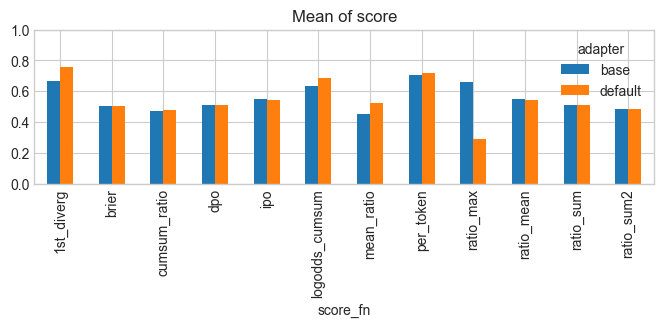

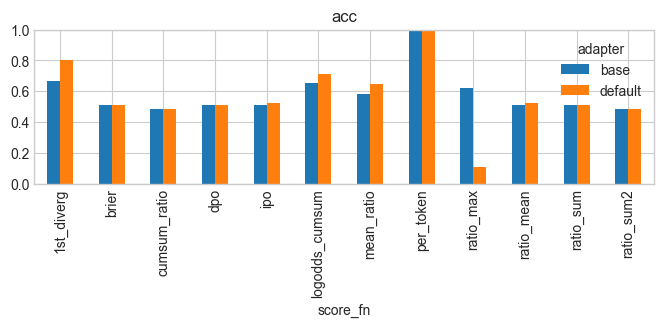

In [ ]:
def diff(x):
    return np.nanmean(x.diff().values)

df_score = pd.DataFrame(scores)
(df_score
 .groupby('score_fn', as_index=True)[['acc', 'pmean']]
 .agg([diff, 'min',  'max'])
 .sort_values(('acc','diff'))
 )
df_score.set_index(['score_fn', 'adapter']).unstack().pmean.plot(kind='bar', figsize=(8,2), title='Mean of score', ylim=(0,1))

df_score.set_index(['score_fn', 'adapter']).unstack().acc.plot(kind='bar', figsize=(8,2), title='acc', ylim=(0,1))

In [ ]:
df_score.set_index(['score_fn', 'adapter']).unstack()#.pmean.plot(kind='bar', figsize=(12,6), title='Mean of score')

pmean                 acc          
adapter             base   default      base   default
score_fn                                              
1st_diverg      0.666575  0.760772  0.666667  0.801282
brier           0.502579  0.503364  0.512821  0.512821
cumsum_ratio    0.474548  0.477108  0.487179  0.487179
dpo             0.512822  0.512822  0.512821  0.512821
ipo             0.552862  0.544827  0.512821  0.525641
logodds_cumsum  0.637438  0.686001  0.653846  0.711538
mean_ratio      0.450898  0.526236  0.583333  0.647436
per_token       0.703424  0.721010  1.000000  1.000000
ratio_max       0.657953  0.292229  0.621795  0.108974
ratio_mean      0.552862  0.544827  0.512821  0.525641
ratio_sum       0.512822  0.512822  0.512821  0.512821
ratio_sum2      0.485324  0.485887  0.487179  0.487179